# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os
import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

In [3]:
!wget -q https://lms-cdn.skillfactory.ru/assets/courseware/v1/b041c8987cf09178b0c352a1ad3af133/asset-v1:SkillFactory+DSPR-CV+ALWAYS+type@asset+block/frey_rawface.zip
!unzip -q frey_rawface.zip
!ls -1

frey_rawface.mat
frey_rawface.zip
sample_data


# Загрузка данных

In [4]:
# Переведем данные в привычный нам NumPy формат
mat_data = scipy.io.loadmat('./frey_rawface.mat')
data = mat_data['ff'].T.reshape(-1, 1, 28, 20)
data = data.astype('float32') / 255.0
print(f"Number of instances: {len(data)}")

Number of instances: 1965


In [5]:
# Подготовка torch датасета
class FreyDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return (len(self.X))
    def __getitem__(self, index):
        data = self.X[index]
        return torch.tensor(data, dtype=torch.float)

## Задание 1. Разделите данные на `train` и `val` части. К `val` отнесите последние 300 объектов. Подготовьте данные для обучения с помощью `FreyDataset` и `DataLoader`.

In [6]:
x_train = FreyDataset(data[:-300])
x_val = FreyDataset(data[-300:])
print(f"Training instances: {len(x_train)}")
print(f"Validation instances: {len(x_val)}")

Training instances: 1665
Validation instances: 300


In [7]:
batch_size = 64

train_loader = DataLoader(
                        x_train,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=os.cpu_count(),
                        pin_memory=True
)
val_loader = DataLoader(
                        x_val,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=os.cpu_count(),
                        pin_memory=True
)

In [8]:
kernel_size = 4
stride = 1
padding = 0
init_kernel = 16

# Вариационныей автоэнкодер

## Задание 2. Допишите трюк репараметризации в функции `reparameterize`.

*Подробнее о трюке можно узнать в [дополнительных материалах](https://drive.google.com/file/d/18LWM4jROW6A89B7XEpH6w66M5BomGUKn/view?usp=sharing).*

In [9]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # энкодер
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=init_kernel, kernel_size=kernel_size,
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size,
            stride=stride, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, kernel_size=kernel_size,
            stride=stride, padding=padding
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size,
            stride=stride, padding=padding
        )
        self.enc5 = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=init_kernel, kernel_size=kernel_size,
            stride=stride, padding=padding
        )
        # декодер
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=init_kernel*8, kernel_size=kernel_size,
            stride=stride, padding=padding
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size,
            stride=stride, padding=padding
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, kernel_size=kernel_size,
            stride=stride, padding=padding
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size,
            stride=stride, padding=padding
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=1, kernel_size=kernel_size,
            stride=stride, padding=padding
        )
    def reparameterize(self, mu, log_var):
        """Generate a random distribution w.r.t. the mu and log_var from the embedding space."""
        
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        sample = mu + eps*std
        return sample

    def forward(self, x):
        # кодирование
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)
        # сэмплирование среднего и logvar
        mu = x
        log_var = x
        # получаем латентное предстваление через репораметризацию
        z = self.reparameterize(mu, log_var)

        # декодирование
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction, mu, log_var

In [10]:
lr = 0.001
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

## Задание 3. Прежде, чем перейти к обучению модели, определите функцию потерь VAE.

In [12]:
def final_loss(bce_loss, mu, logvar):

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce_loss + KLD

## Обучение модели

In [13]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(x_train)/dataloader.batch_size)):
        data= data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [14]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(x_val)/dataloader.batch_size)):
            data= data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()

            # save the last batch input and output of every epoch
            if i == int(len(x_val)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8],
                                  reconstruction[:8]))
                save_image(both.cpu(), f"./output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [15]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20


27it [00:09,  2.76it/s]                        
5it [00:00, 42.67it/s]               

Train Loss: 379.6867
Val Loss: 365.9024
Epoch 2 of 20



27it [00:00, 87.94it/s]                         
5it [00:00, 69.41it/s]               

Train Loss: 362.6673
Val Loss: 355.6297
Epoch 3 of 20



27it [00:00, 85.17it/s]                        
5it [00:00, 67.91it/s]               

Train Loss: 356.4664
Val Loss: 352.9520
Epoch 4 of 20



27it [00:00, 88.61it/s]                         
5it [00:00, 63.48it/s]               

Train Loss: 354.1550
Val Loss: 351.7115
Epoch 5 of 20



27it [00:00, 87.84it/s]                        
5it [00:00, 71.06it/s]               

Train Loss: 353.3324
Val Loss: 351.0943
Epoch 6 of 20



27it [00:00, 88.68it/s]                         
5it [00:00, 64.34it/s]               

Train Loss: 352.9442
Val Loss: 350.5139
Epoch 7 of 20



27it [00:00, 86.27it/s]                        
5it [00:00, 64.03it/s]               

Train Loss: 352.7491
Val Loss: 351.2880
Epoch 8 of 20



27it [00:00, 67.31it/s]
5it [00:00, 45.62it/s]               

Train Loss: 352.5757
Val Loss: 350.5396
Epoch 9 of 20



27it [00:00, 65.10it/s]                        
5it [00:00, 41.65it/s]               

Train Loss: 352.5165
Val Loss: 350.9553
Epoch 10 of 20



27it [00:00, 65.74it/s]                        
5it [00:00, 39.89it/s]               

Train Loss: 352.4775
Val Loss: 350.9870
Epoch 11 of 20



27it [00:00, 82.46it/s]                        
5it [00:00, 71.85it/s]               

Train Loss: 352.4884
Val Loss: 351.2364
Epoch 12 of 20



27it [00:00, 88.45it/s]                         
5it [00:00, 73.75it/s]               

Train Loss: 352.4090
Val Loss: 350.5051
Epoch 13 of 20



27it [00:00, 86.58it/s]                         
5it [00:00, 53.59it/s]               

Train Loss: 352.3726
Val Loss: 350.4868
Epoch 14 of 20



27it [00:00, 88.03it/s]                         
5it [00:00, 66.99it/s]               

Train Loss: 352.3710
Val Loss: 351.3987
Epoch 15 of 20



27it [00:00, 87.43it/s]                        
5it [00:00, 64.62it/s]               

Train Loss: 352.3622
Val Loss: 350.7620
Epoch 16 of 20



27it [00:00, 86.92it/s]                         
5it [00:00, 65.21it/s]               

Train Loss: 352.3179
Val Loss: 351.1055
Epoch 17 of 20



27it [00:00, 83.61it/s]                        
5it [00:00, 66.92it/s]               

Train Loss: 352.3173
Val Loss: 350.8013
Epoch 18 of 20



27it [00:00, 87.94it/s]                         
5it [00:00, 63.95it/s]               

Train Loss: 352.3235
Val Loss: 350.6661
Epoch 19 of 20



27it [00:00, 84.80it/s]                        
5it [00:00, 66.44it/s]               

Train Loss: 352.3276
Val Loss: 350.4825
Epoch 20 of 20



27it [00:00, 88.79it/s]                         
5it [00:00, 65.83it/s]               

Train Loss: 352.2803
Val Loss: 350.8683


## Визуализация полученных изображений

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

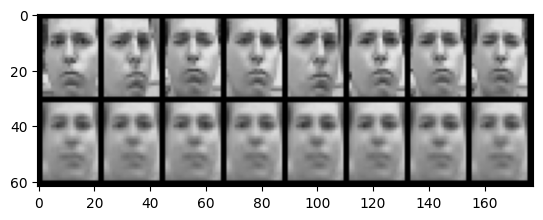

In [17]:
# 10я эпоха
image_10 = Image.open("output10.png")
plt.imshow(image_10)

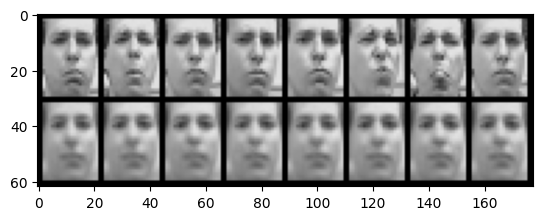

In [18]:
# 19я эпоха
image_19 = Image.open("output19.png")
plt.imshow(image_19)